Simple outline for this notebook:   

1. Introduce the logic of the current code.

2. Show the whole code of the k-nearest p-median model.

3. Use the example to test the model.

#### 1. The logic

a. The logic of `k_nearest_loop()`.   

It can find the optimal solution, when the coordinate information of clients and facilities and the intial k value are given.

![Flowchart](flowchart/k_nearest_loop()_coordinate.png)

b. The content of `from_sparse_matrix()`

1. Three types of decision variables:   
    one for the pair between clients and facilities,     
    one for the placeholder facilities,     
    one for all the facilities.

2. One objective function

3. Three types of constraints:   
    one is about assignment constraint (each client must be served by one facility);    
    one is about the overall accommodation constraint (the whole facilities are able to serve all the demands);    
    the last one is about the individual capacity constraint (each facility has a capacity)

c. (don't need to do this part) to deal with the problem that `KDtree` using `Euclidean distance`

1. The idea is from:   
     https://stackoverflow.com/questions/43020919/scipy-how-to-convert-kd-tree-distance-from-query-to-kilometers-python-pandas   
    https://github.com/qingkaikong/blog/tree/master/2017_33_kdtree_2_real_distance

2. Before using KDtree, converting the latitude and longitude of the points to 3D cartesian coordinates. Then do the KD-tree query in this cartesian coordinates.

3. The distance returned from KDtree query, is cartesian distance. We need to convert it to real distance in km. Then transfer the data to sparse matrix.

#### 2. The complete code (binary version + Euclidean distance version)

In [127]:
import pandas as pd
import numpy as np
import pulp
from scipy.sparse import csr_matrix
from scipy.sparse import find
from scipy.spatial import KDTree
from pointpats.geometry import build_best_tree

In [113]:
def create_sparse_matrix(clients, facilities, k_list, metric):
    """
    create a sparse matrix reprensents the distance between clients and their k nearest facilities
    """
    row_shape = len(clients)
    column_shape = len(facilities)

    # check the k value with the total number of facilities
    for k in k_list:
        if k > column_shape:
            raise ValueError(f"The value of k should be no more than the number of total facilities ({column_shape}).")

    # Initialize empty lists to store the data for the sparse matrix
    data = []
    row_index = []
    col_index = []

    # create the suitable Tree
    tree = build_best_tree(facilities, metric)

    for i, k in enumerate(k_list):
        # Query the Tree to find the k nearest facilities for each client
        distances, k_nearest_facilities_indices = tree.query([clients[i]], k=k)

        # extract the contents of the inner array
        distances = distances[0].tolist()
        k_nearest_facilities_indices = k_nearest_facilities_indices[0].tolist()
        
        # Append the data for the sparse matrix
        data.extend(distances)
        row_index.extend([i] * k)
        col_index.extend(k_nearest_facilities_indices)
    # Create the sparse matrix using csr_matrix
    sparse_matrix = csr_matrix((data, (row_index, col_index)), shape=(row_shape, column_shape))
    return sparse_matrix

def create_k_list(decision_g, k_list):
    """
    increase the k value of client with the g_i > 0, create a new k list
    """
    new_k_list = k_list.copy()
    for i in range(len(decision_g)):
        if decision_g[i].value() > 0:
            new_k_list[i] = new_k_list[i] + 1
    return new_k_list

def from_sparse_matrix(sparse_distance_matrix, demand=None, capacity=None):
    """
    create and solve a p-median problem of a given sparse distance matrix, and demand and capacity
    """
    # get the indices for clients and facilities
    n_cli = sparse_distance_matrix.shape[0]
    r_cli = range(n_cli)
    r_fac = range(sparse_distance_matrix.shape[1])

    # get the demand
    demand_sum = demand.sum()
    demand = np.reshape(demand, (n_cli, 1))

    # find the indices in this matrix
    row_indices, col_indices, values = find(sparse_distance_matrix)

    # set up the problem
    problem = pulp.LpProblem("k-nearest-p-median", pulp.LpMinimize)

    # set the decision variable for the pair between client and k nearest facilities
    decision = pulp.LpVariable.dicts("x", [(i, j) for i, j in zip(row_indices, col_indices)], 0, 1, pulp.LpBinary)

    # set the decision variable for placeholder facility
    decision_g = pulp.LpVariable.dicts("g", (i for i in r_cli), 0, 1, pulp.LpBinary)

    # set the decision variable for all the facilities
    decision_f = pulp.LpVariable.dicts("y", (j for j in r_fac), 0, 1, pulp.LpBinary)

    # set the objective
    # to complete the objective, we need to get the maximum distance for each client first
    max_distance = sparse_distance_matrix.max(axis=1).toarray().flatten()
    objective = pulp.lpSum(
        pulp.lpSum(
            decision.get((i, j), 0) * sparse_distance_matrix[i, j] for j in r_fac
        )
        + (decision_g[i] * (max_distance[i] + 1))
        for i in r_cli
    )
    problem += objective

    # constraint 1. Each client is assigned to a facility
    for i in r_cli:
        problem += (
            pulp.lpSum(decision.get((i, j), 0) for j in r_fac)
            + decision_g[i] == 1
        )

    # constraint 2. The amount of capacity equals or exceeds the sum of all demands
    problem += pulp.lpSum(decision_f[j] * capacity[j] for j in r_fac) >= demand_sum

    # constraint 3. Demand value the k nearest facility can serve is no more than its capacity.
    for j in col_indices:
        problem += (
            pulp.lpSum(demand[i] * decision.get((i, j), 0) for i in r_cli) <= decision_f[j] * capacity[j]
        )

    problem.solve(pulp.PULP_CBC_CMD(msg=False))
    return problem, decision, decision_g
    
def k_nearest_loop(
    k_list, client, facility, demand=None, capacity=None, metric = 'euclidean'
    ):
    """
    the iteration which can find the optimal solution of the given coordinate of clients and facilities and k value
    """
    sum_gi = 1
    while sum_gi > 0:
        sparse_distance_matrix = create_sparse_matrix(client, facility, k_list, metric)
        prob, decision, decision_g = from_sparse_matrix(
            sparse_distance_matrix, demand=demand, capacity=capacity)
        if prob.status != 1:
            print("This problem doesn't have the optimal solution")
            break
        sum_gi = sum(decision_g[i].value() for i in range(len(decision_g)) if decision_g[i].value() > 0)
        if sum_gi > 0:
            k_list = create_k_list(decision_g, k_list)
    return prob, decision, decision_g, k_list

#### 3. Test case

##### a. simple case, set the intial k equal to 1, and through the loop, it needs to be increased to 2.

In [93]:
sample_client = np.array([[0.5, 1], [1.5, 1]])
sample_facility = np.array([[1,1], [0, 2], [2, 0]])

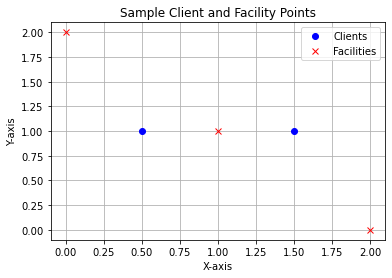

In [100]:
import matplotlib.pyplot as plt

client_x, client_y = sample_client[:, 0], sample_client[:, 1]
facility_x, facility_y = sample_facility[:, 0], sample_facility[:, 1]

plt.plot(client_x, client_y, 'bo', label='Clients')  # 'bo' means blue color and circular marker for clients
plt.plot(facility_x, facility_y, 'rx', label='Facilities')  # 'rx' means red color and 'x' marker for facilities

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Sample Client and Facility Points')
plt.legend()

plt.grid()
plt.show()

In [94]:
prob, decision, decision_g = k_nearest_loop(
    [1, 1], sample_client, sample_facility, demand=np.array([1, 1]), capacity=np.array([1, 1, 1]))

In [95]:
prob.status

1

In [96]:
for i in range(2):
    for j in range(3):
        if (i, j) in decision and decision[(i, j)].value() == 1:
            print(i, j)

0 1
1 0


##### b. more complicated case

In [104]:
sample_client_b = np.array([[10.5, 1], [11.5, 1], [13.5, 1], [14.5, 1], [16.5, 1], [17.5, 1]])
sample_facility_b = np.array([[11,1], [10, 2], [12, 0], [14,1], [13, 2], [15, 0], [17,1], [16, 2], [18, 0]])

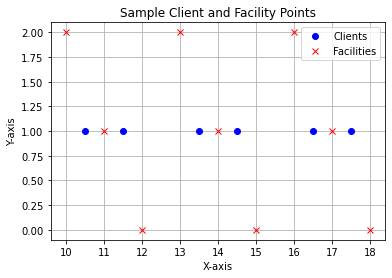

In [105]:
client_x, client_y = sample_client_b[:, 0], sample_client_b[:, 1]
facility_x, facility_y = sample_facility_b[:, 0], sample_facility_b[:, 1]

plt.plot(client_x, client_y, 'bo', label='Clients')  # 'bo' means blue color and circular marker for clients
plt.plot(facility_x, facility_y, 'rx', label='Facilities')  # 'rx' means red color and 'x' marker for facilities

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Sample Client and Facility Points')
plt.legend()

plt.grid()
plt.show()

In [108]:
intial_k = [1, 1, 1, 1, 1, 1]
demand_b = np.array([1, 1, 1, 1, 1, 1])
capacity_b = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])

In [114]:
prob, decision, decision_g, k_list = k_nearest_loop(
    intial_k, sample_client_b, sample_facility_b, demand=demand_b, capacity=capacity_b)

In [115]:
prob.status

1

In [116]:
for i in range(6):
    for j in range(9):
        if (i, j) in decision and decision[(i, j)].value() == 1:
            print(i, j)

0 1
1 0
2 4
3 3
4 7
5 6


In [118]:
k_list

[2, 1, 2, 1, 2, 1]

#### 4. error handling

##### a. the k value should be no more than the total number of facilities

In [21]:
prob, decision, decision_g = k_nearest_loop(
    [4, 4], sample_client, sample_facility, demand=np.array([1, 1]), capacity=np.array([1, 1, 1]))

ValueError: The value of k should be no more than the number of total facilities (3).